In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
data = pd.read_csv("/kaggle/input/sparkathon-data/data.csv")
data.drop(columns = 'review_id' , inplace = True, axis = 1 )
data.drop('review_title' , inplace = True , axis = 1 ) 
data.drop('review_content' , inplace = True , axis = 1 )
data.drop('product_link' , inplace = True , axis =1 )
data.drop('about_product' , inplace = True , axis = 1 )
data.head(3)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,user_id,user_name,img_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269","AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...",https://m.media-amazon.com/images/W/WEBP_40237...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...",https://m.media-amazon.com/images/W/WEBP_40237...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928","AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...",https://m.media-amazon.com/images/W/WEBP_40237...


In [9]:
for i in range(len(data['rating'])):
    try:
        data['rating'][i] = float(data['rating'][i])
    except:
        data['rating'][i] = 4.1

In [10]:
tempData = pd.DataFrame(columns=data.columns)

for i in range(len(data)):
    user_ids = data['user_id'][i].split(',')
    user_names = data['user_name'][i].split(',')
    meanRating = float(data['rating'][i])
    ratings = np.random.normal(loc=meanRating, scale=0.5, size=len(user_ids))
    ratings = np.clip(ratings, 1, 5)
    
    for j in range(len(user_ids)):
        temp = data.loc[i].copy()  
        temp['user_id'] = user_ids[j]
        temp['user_name'] = user_names[j]
        temp['rating'] = ratings[j]
        tempData.loc[len(tempData)] = temp

data = tempData.copy()

# Standardize ratings
scaler = StandardScaler()
data['rating'] = scaler.fit_transform(data[['rating']])

# Create user and product dictionaries
userDict = {}
productDict = {}
value = 0

for userID in data['user_id'].unique():
    if userID not in userDict:
        userDict[userID] = value
        userDict[value] = userID
        value += 1

value = 0
for productID in data['product_id'].unique():
    if productID not in productDict:
        productDict[productID] = value
        productDict[value] = productID
        value += 1

# Map IDs
df = data[['user_id', 'product_id', 'rating']]
df['user_id'] = df['user_id'].map(userDict)
df['product_id'] = df['product_id'].map(productDict)

# Ratings matrix
ratingsMatrix = np.zeros((len(userDict), len(productDict)))

for i in range(len(df)): 
    userID = df['user_id'][i]
    productID = df['product_id'][i]
    ratingsMatrix[userID][productID] = df['rating'][i]



In [11]:
ratingsMatrix.shape

(18100, 2702)

In [20]:
embeddings_dim = 128
batch_size = 64
lr = 0.001

In [21]:
# Define Dataset
class RatingsDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user = torch.tensor(self.data.iloc[idx]['user_id'], dtype=torch.long)
        product = torch.tensor(self.data.iloc[idx]['product_id'], dtype=torch.long)
        rating = torch.tensor(self.data.iloc[idx]['rating'], dtype=torch.float)
        return torch.stack([user, product]), rating

# Define Model
class RecommenderModel(nn.Module):
    def __init__(self, num_users, num_products, embedding_dim):
        super(RecommenderModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.product_embedding = nn.Embedding(num_products, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        user_emb = self.user_embedding(x[:, 0])
        product_emb = self.product_embedding(x[:, 1])
        x = torch.cat([user_emb, product_emb], dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

# Split data
# train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = RatingsDataset(df)
# val_dataset = RatingsDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize model, loss function, and optimizer
num_users = len(userDict)
num_products = len(productDict)
model = RecommenderModel(num_users, num_products, embedding_dim = 128 )
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training function
def train_model(model, train_loader, optimizer, criterion, device, epochs , train_losses ):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x).squeeze()
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")
    return model, train_losses

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_losses = []
model, train_losses = train_model(model=model, train_loader=train_loader, optimizer=optimizer, criterion  = criterion, device = device , train_losses = train_losses ,epochs = 10  )


Epoch: 1/10, Train Loss: 1.0310
Epoch: 2/10, Train Loss: 0.9665
Epoch: 3/10, Train Loss: 0.9173
Epoch: 4/10, Train Loss: 0.8573
Epoch: 5/10, Train Loss: 0.8047
Epoch: 6/10, Train Loss: 0.7614
Epoch: 7/10, Train Loss: 0.7284
Epoch: 8/10, Train Loss: 0.7046
Epoch: 9/10, Train Loss: 0.6859
Epoch: 10/10, Train Loss: 0.6747


In [23]:
model, train_losses = train_model(model=model, train_loader=train_loader, optimizer=optimizer, criterion  = criterion, device = device , train_losses = train_losses ,epochs = 10  )


Epoch: 1/10, Train Loss: 0.6662
Epoch: 2/10, Train Loss: 0.6607
Epoch: 3/10, Train Loss: 0.6570
Epoch: 4/10, Train Loss: 0.6540
Epoch: 5/10, Train Loss: 0.6503
Epoch: 6/10, Train Loss: 0.6490
Epoch: 7/10, Train Loss: 0.6474
Epoch: 8/10, Train Loss: 0.6463
Epoch: 9/10, Train Loss: 0.6445
Epoch: 10/10, Train Loss: 0.6441


In [26]:
model, train_losses = train_model(model=model, train_loader=train_loader, optimizer=optimizer, criterion  = criterion, device = device , train_losses = train_losses ,epochs = 10  )


Epoch: 1/10, Train Loss: 0.6175
Epoch: 2/10, Train Loss: 0.6178
Epoch: 3/10, Train Loss: 0.6178
Epoch: 4/10, Train Loss: 0.6178
Epoch: 5/10, Train Loss: 0.6179
Epoch: 6/10, Train Loss: 0.6176
Epoch: 7/10, Train Loss: 0.6181
Epoch: 8/10, Train Loss: 0.6182
Epoch: 9/10, Train Loss: 0.6175
Epoch: 10/10, Train Loss: 0.6177


In [28]:
model, train_losses = train_model(model=model, train_loader=train_loader, optimizer=optimizer, criterion  = criterion, device = device , train_losses = train_losses ,epochs = 10  )


Epoch: 1/10, Train Loss: 0.6177
Epoch: 2/10, Train Loss: 0.6174
Epoch: 3/10, Train Loss: 0.6175
Epoch: 4/10, Train Loss: 0.6177
Epoch: 5/10, Train Loss: 0.6176
Epoch: 6/10, Train Loss: 0.6177
Epoch: 7/10, Train Loss: 0.6175
Epoch: 8/10, Train Loss: 0.6174
Epoch: 9/10, Train Loss: 0.6173
Epoch: 10/10, Train Loss: 0.6176


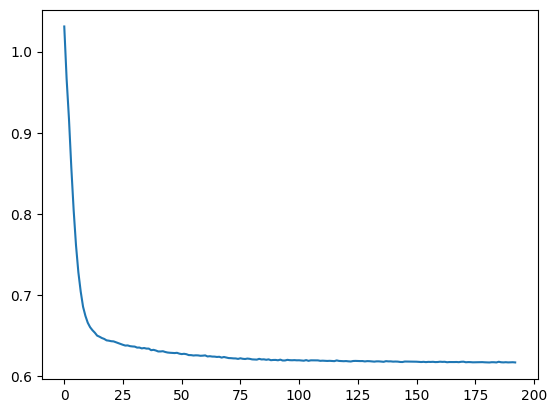

In [30]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

In [65]:
def recommend_products(model, user_id, userDict, productDict, device):
    l = [] 
    productIds = []
    for i in productDict.keys():
        if(not isinstance(i, str)):
            l.append(np.array([user_id , i ]) )
            productIds.append(i)
    x = np.array(l)
    x = torch.tensor(x)
    model.eval()
    x = x.to(device)
    output = model(x).squeeze()
    recommendations = pd.DataFrame()
    recommendations['productID'] = productIds
    scores = []
    for i in range(len(productIds)):
        scores.append(output[i].item())
    recommendations['rating'] = scores
    
    recommendations = recommendations.sort_values(by='rating', ascending=False)
    return recommendations

In [66]:
recommend_products(model, 1 , userDict, productDict, device)

,productID,rating
1087,1087,9.710618e-01
203,203,9.578031e-01
1175,1175,9.411776e-01
376,376,9.376597e-01
156,156,9.362581e-01
...,...,...
135,135,5.089268e-08
347,347,3.078424e-08
328,328,1.638317e-08
388,388,8.998131e-09


In [78]:
torch.save(model , 'model.pth')